In [1]:
import os
import time

import matplotlib.pyplot as plt
import numpy as np
import psutil
import tensorflow as tf
from scipy.stats import pearsonr
from tensorflow.keras.layers import Dense, Input, LeakyReLU
from tensorflow.keras.models import Model

from modules.training.normlayer import NormalizeLayer
from modules.training.phase_manager import IsTraining

# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

from modules.training.cme_modeling import ModelBuilder as MB

C:\Users\the_3\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\the_3\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
from modules.training.phase_manager import TrainingPhaseManager

# instantiate the model_builder
mb = MB()
pm = TrainingPhaseManager()  # Training phase manager

In [3]:
def benchmark_function(func, args=(), kwargs=None, num_runs=100):
    """
    Generic benchmark utility for any function.
    
    :param func: Function to benchmark
    :param args: Tuple of positional arguments for the function
    :param kwargs: Dictionary of keyword arguments for the function
    :param num_runs: Number of runs for averaging timing
    :return: Dictionary containing timing and memory statistics
    """
    if kwargs is None:
        kwargs = {}
    global result
    process = psutil.Process(os.getpid())
    execution_times = []
    memory_usages = []

    # Warmup run
    _ = func(*args, **kwargs)

    # Clear any cached memory
    tf.keras.backend.clear_session()

    for _ in range(num_runs):
        mem_before = process.memory_info().rss / 1024 / 1024

        start_time = time.perf_counter()
        result = func(*args, **kwargs)
        end_time = time.perf_counter()

        mem_after = process.memory_info().rss / 1024 / 1024

        execution_times.append(end_time - start_time)
        memory_usages.append(mem_after - mem_before)

        tf.keras.backend.clear_session()

    times_ms = np.array(execution_times) * 1000
    memory_mb = np.array(memory_usages)

    return {
        'time_mean_ms': np.mean(times_ms),
        'time_std_ms': np.std(times_ms),
        'memory_mean_mb': np.mean(memory_mb),
        'memory_max_mb': np.max(memory_mb),
        'last_result': result
    }

In [3]:
y_true = tf.constant([[1.0],
                      [5.0],
                      [0.0]])

z_pred = tf.constant([[1.0, 1.0],
                      [2.0, -1.0],
                      [3.0, 1.0]])

# create sample weights dictionary of label weights pairs
# Create dictionary mapping label values to weights
sample_weights = {
    1.0: 0.5,  # Weight for label 1.0
    5.0: 1.0,  # Weight for label 5.0 
    0.0: 0.8   # Weight for label 0.0
}



# print shapes
print(f"y_true shape: {y_true.shape}")
print(f"z_pred shape: {z_pred.shape}")

y_true shape: (3, 1)
z_pred shape: (3, 2)


In [4]:
res = mb.pds_loss_vec(y_true, z_pred, pm, train_sample_weights=sample_weights)
print(f'Result: {res.numpy():.4f}')

Result: 6.7705


In [6]:
res = mb.pds_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 3.9169


In [7]:
res = mb.pdc_loss_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0293


In [8]:
res = mb.pdc_loss_linear_vec(y_true, z_pred, pm)
print(f'Result: {res.numpy():.4f}')

Result: 0.0293


In [9]:
# Parameters
num_points = 5000  # 201 points for labels from -100 to 100 inclusive

# Create evenly spaced labels from -100 to 100
labels = np.linspace(-5000, 5000, num_points)
# update the dimension of labels
labels = np.expand_dims(labels, axis=1)

# Generate points like (0, 0), (1, 1), ..., (200, 200)
points = np.array([(i, i) for i in range(num_points)])

# convert to tensor float32
labels = tf.constant(labels, dtype=tf.float32)
points = tf.constant(points, dtype=tf.float32)

print(f"Labels shape: {labels.shape}")
print(f"Points shape: {points.shape}")

# Random sample weights between 0 and 1
sample_weights = np.random.rand(num_points)

Labels shape: (5000, 1)
Points shape: (5000, 2)


In [10]:
stats = benchmark_function(
    mb.pds_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 1432014.2500
Time: 52.336 ± 11.032 ms
Memory peak: 0.184 MB


In [11]:
stats = benchmark_function(
    mb.pds_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 1431728.0000
Time: 47.245 ± 33.454 ms
Memory peak: 0.121 MB


In [12]:
stats = benchmark_function(
    mb.pdc_loss_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: 0.0000
Time: 67.388 ± 27.847 ms
Memory peak: 0.000 MB


In [17]:
stats = benchmark_function(
    mb.pdc_loss_linear_vec,
    args=(labels, points, pm),
    num_runs=100
)

print(f"Result: {stats['last_result'].numpy():.4f}")
print(f"Time: {stats['time_mean_ms']:.3f} ± {stats['time_std_ms']:.3f} ms")
print(f"Memory peak: {stats['memory_max_mb']:.3f} MB")

Result: -0.0000
Time: 32.672 ± 2.736 ms
Memory peak: 0.008 MB


In [3]:
class TrainerV4:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)
        model = Model(inputs=inputs, outputs=outputs)
        return model

    def generate_synthetic_data(self, num_points=200):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, verbose=1):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=num_points)

        # Compile model
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss=loss_fn
        )

        # Convert to tf.data.Dataset
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions
        predictions = self.model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()

In [26]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pds_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=5000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)


KeyboardInterrupt: 

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 6s 21ms/step - loss: 0.9968
Epoch 2/250
5/5 [==============================] - 0s 15ms/step - loss: 0.9692
Epoch 3/250
5/5 [==============================] - 0s 12ms/step - loss: 0.9272
Epoch 4/250
5/5 [==============================] - 0s 12ms/step - loss: 0.8401
Epoch 5/250
5/5 [==============================] - 0s 13ms/step - loss: 

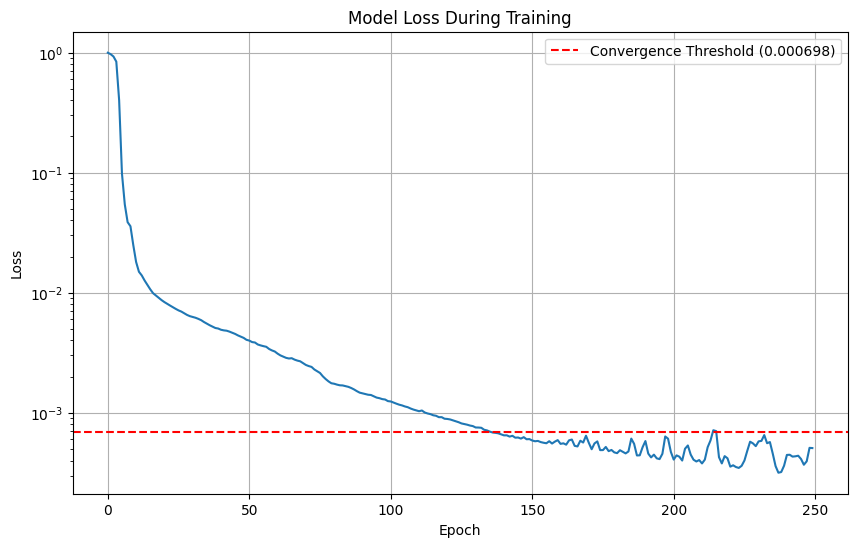

32/32 [==============================] - 0s 2ms/step


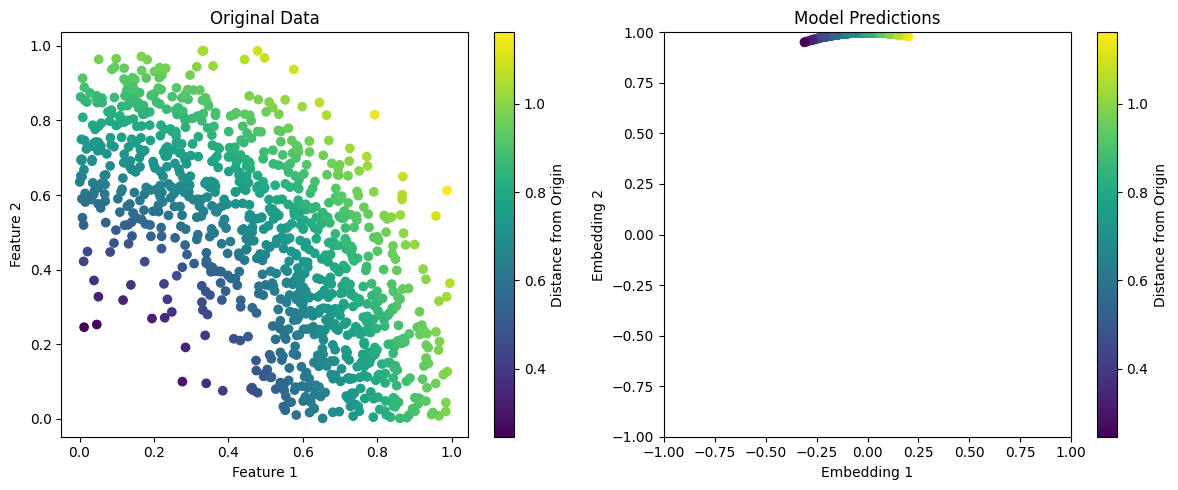

In [4]:
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=5000, epochs=250, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/250
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


C:\Users\the_3\anaconda3\envs\tf-gpu\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("Adam/gradients/concat_1:0", shape=(None,), dtype=int32), values=Tensor("Adam/gradients/concat:0", shape=(None, 2), dtype=float32), dense_shape=Tensor("gradient_tape/custom_loss/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


5/5 [==============================] - 1s 12ms/step - loss: 1.0018
Epoch 2/250
5/5 [==============================] - 0s 13ms/step - loss: 0.9611
Epoch 3/250
5/5 [==============================] - 0s 10ms/step - loss: 0.7725
Epoch 4/250
5/5 [==============================] - 0s 9ms/step - loss: 0.3459
Epoch 5/250
5/5 [==============================] - 0s 10ms/step - loss: 0.1726
Epoch 6/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0625
Epoch 7/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0385
Epoch 8/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0205
Epoch 9/250
5/5 [==============================] - 0s 9ms/step - loss: 0.0110
Epoch 10/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0107
Epoch 11/250
5/5 [==============================] - 0s 10ms/step - loss: 0.0090
Epoch 12/250
5/5 [==============================] - 0s 11ms/step - loss: 0.0080
Epoch 13/250
5/5 [==============================] - 0s 10ms/step

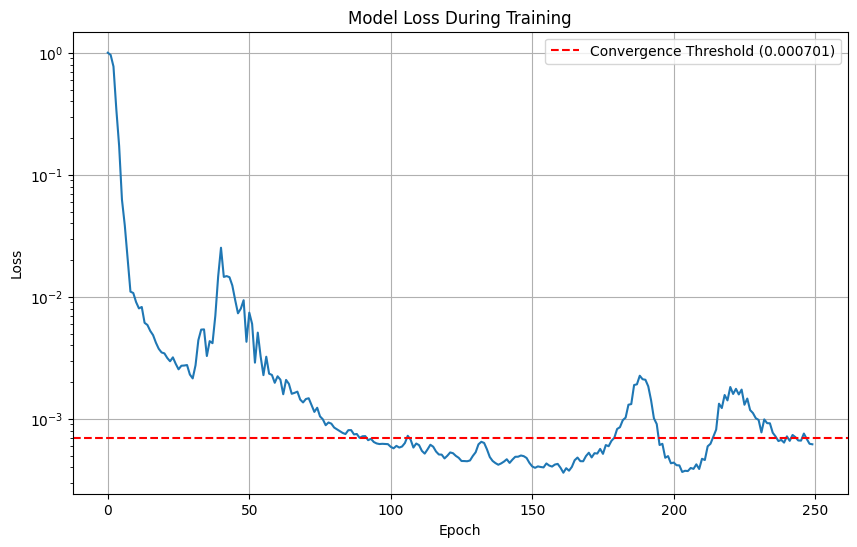

32/32 [==============================] - 0s 5ms/step


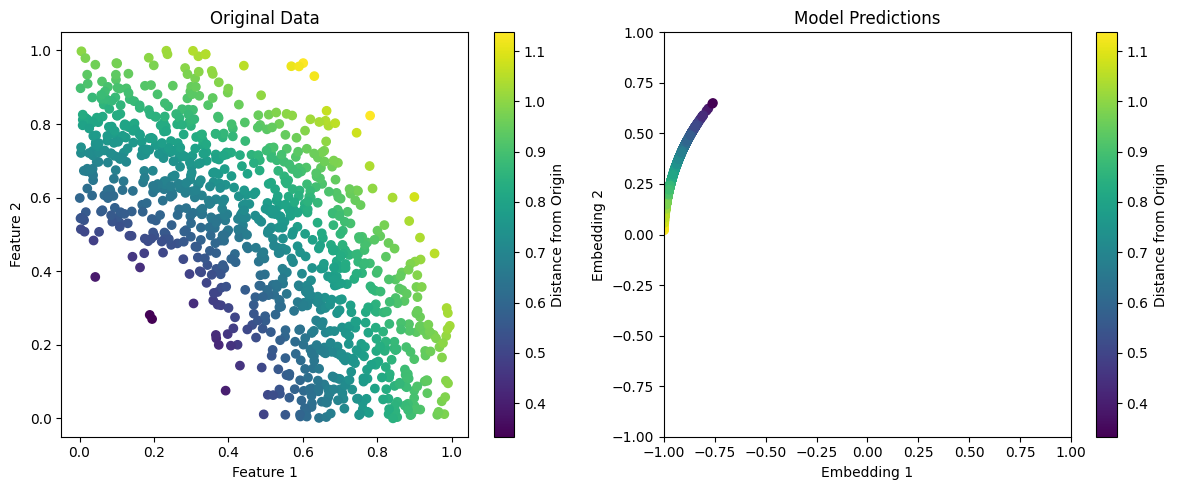

In [5]:
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=5000, epochs=250, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/500
5/5 [==============================] - 3s 42ms/step - loss: 0.0622
Epoch 2/500
5/5 [==============================] - 0s 39ms/step - loss: 0.0268
Epoch 3/500
5/5 [==============================] - 0s 23ms/step - loss: 0.0289
Epoch 4/500
5/5 [==============================] - 0s 13ms/step - loss: 0.0290
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0280
Epoch 6/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0259
Epoch 7/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0222
Epoch 8/500
5/5 [==============================] - 0s 11ms/step - loss: 0.0180
Epoch 9/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0168
Epoch 10/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0151
Epoch 11/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0124
Epoch 12/500
5/5 [==============================] - 0s 12ms/step - loss: 0.0103
Epoch 13/500
5/5 [==============================]

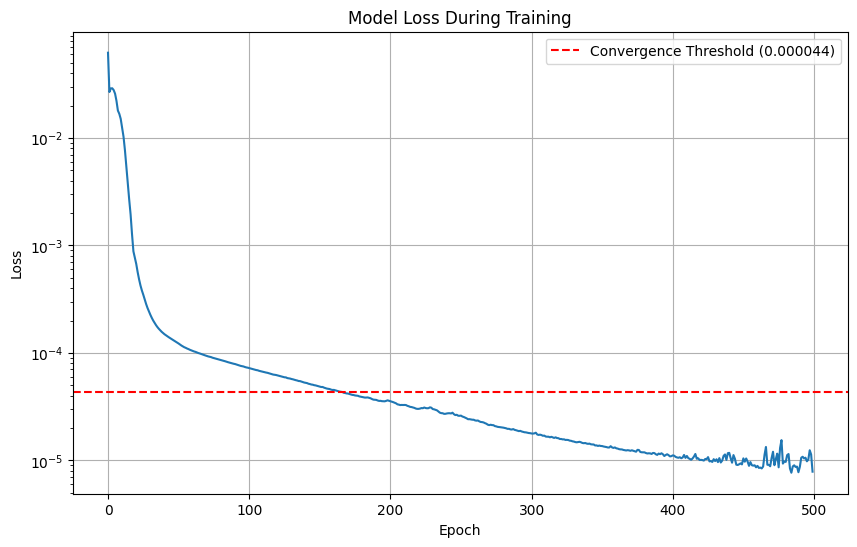

32/32 [==============================] - 0s 4ms/step


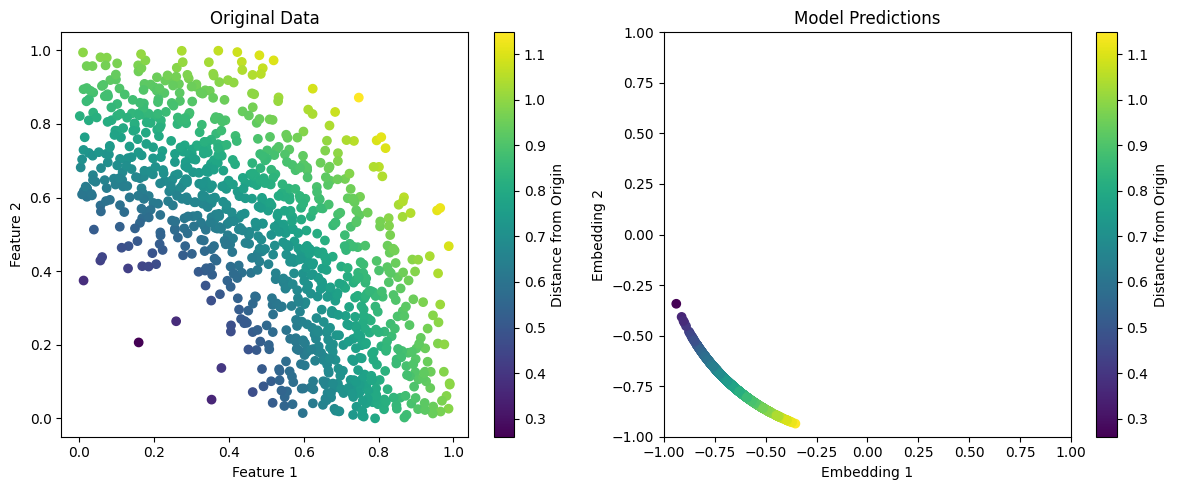

In [18]:
def custom_loss(y_true, y_pred):
    return mb.pds_loss_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV4(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=5000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

Epoch 1/500
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2/2 [==============================] - 2s 11ms/step - loss: 0.9885
Epoch 2/500
2/2 [==============================] - 0s 10ms/step - loss: 0.9922
Epoch 3/500
2/2 [==============================] - 0s 11ms/step - loss: 0.9756
Epoch 4/500
2/2 [==============================] - 0s 9ms/step - loss: 0.9532
Epoch 5/500
2/2 [==============================] - 0s 8ms/step - loss: 0.

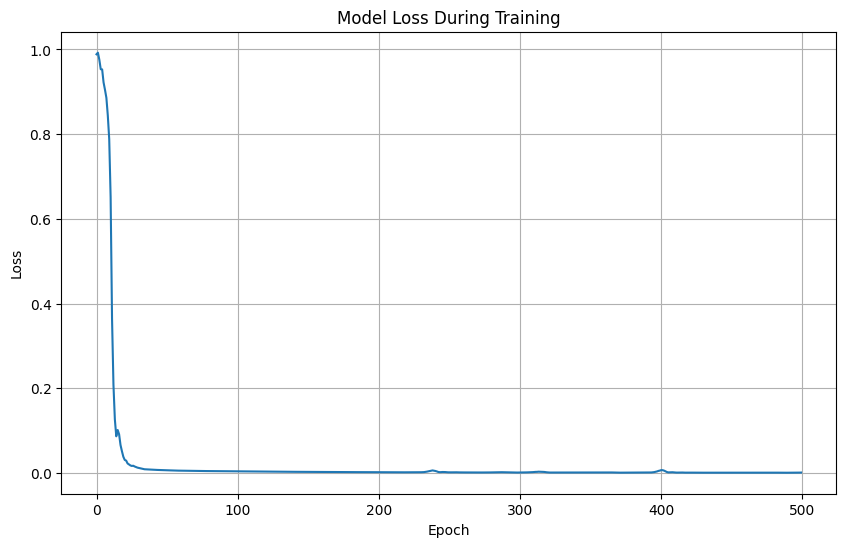

32/32 [==============================] - 0s 2ms/step


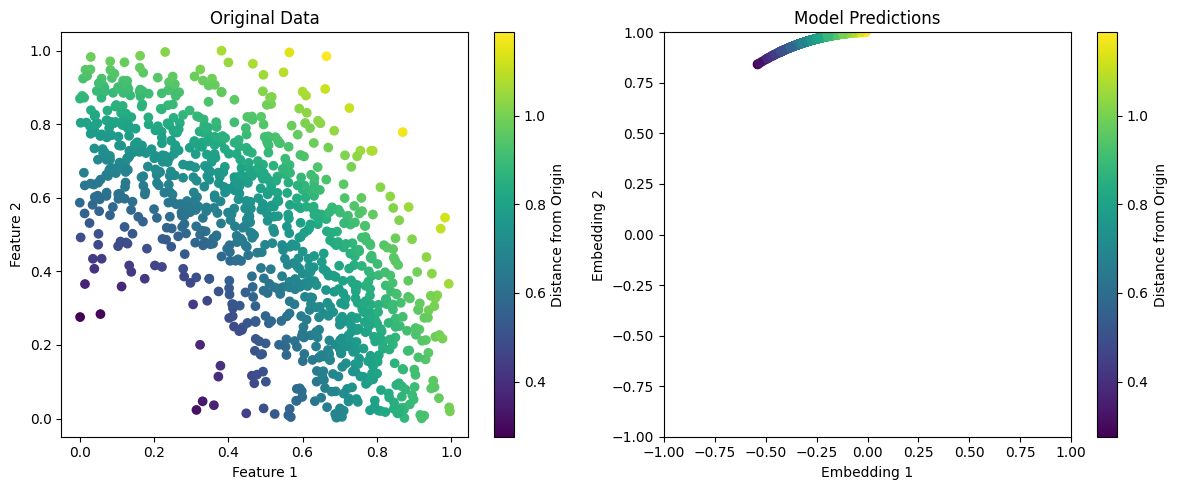

In [7]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function


trainer = TrainerV2(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=False)
history, final_correlation = trainer.train(loss_fn=custom_loss, num_points=2000, epochs=500, batch_size=1024)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Plot predictions
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)
predictions = trainer.model.predict(X_test)
trainer.plot_predictions(X_test, y_test, predictions)

In [20]:
class TrainerV5:
    def __init__(self, input_dim=2, hidden_dims=None, output_dim=2, ae=False):
        if hidden_dims is None:
            hidden_dims = [64, 32]
        self.input_dim = input_dim
        self.hidden_dims = hidden_dims
        self.output_dim = output_dim
        self.ae = ae
        self.encoder_model = None
        self.phase_manager = TrainingPhaseManager()
        self.model = self.build_model()
        self.convergence_threshold = None
        

    def build_model(self):
        inputs = Input(shape=(self.input_dim,))
        x = inputs

        # Hidden layers with Leaky ReLU activation
        for dim in self.hidden_dims:
            x = Dense(dim)(x)
            x = LeakyReLU()(x)

        # Output layer (Encoder output)
        outputs = Dense(self.output_dim)(x)
        outputs = NormalizeLayer(name='normalize_layer')(outputs)

        if not self.ae:
            model = Model(inputs=inputs, outputs=outputs)
            self.encoder_model = model
        else:
            # Build decoder
            decoder_x = outputs
            for dim in reversed(self.hidden_dims):
                decoder_x = Dense(dim)(decoder_x)
                decoder_x = LeakyReLU()(decoder_x)
            reconstructed = Dense(self.input_dim)(decoder_x)
            model = Model(inputs=inputs, outputs=[outputs, reconstructed])
            self.encoder_model = Model(inputs=inputs, outputs=outputs)

        return model

    def generate_synthetic_data(self, num_points=200):
        """
        Generate synthetic data where:
        - Features are random 2D points with coordinates between 0 and 1
        - Labels are distances from origin (0,0)
        - Middle distances are ~10x more frequent than extremes
        """
        # Generate more points than needed for sampling
        pool_size = num_points * 10
        features = np.random.uniform(0, 1, (pool_size, self.input_dim))

        # Calculate distances
        distances = np.sqrt(np.sum(features ** 2, axis=1))

        # Create weights favoring middle distances
        # Use a gaussian centered at ~0.75 (middle of the possible range 0 to √2)
        weights = np.exp(-((distances - 0.75) ** 2) / (2 * 0.15 ** 2))

        # Normalize weights to probabilities
        weights = weights / np.sum(weights)

        # Sample indices according to weights
        selected_indices = np.random.choice(
            pool_size,
            size=num_points,
            p=weights,
            replace=False
        )

        # Select the points
        selected_features = features[selected_indices]
        selected_distances = distances[selected_indices]

        return selected_features, selected_distances.reshape(-1, 1)

    def compute_pairwise_correlation(self, features, predictions):
        """Compute pairwise correlation between features and predictions."""
        feat_dists = tf.reduce_sum(tf.square(features[:, tf.newaxis] - features[tf.newaxis, :]), axis=-1)
        pred_dists = tf.reduce_sum(tf.square(predictions[:, tf.newaxis] - predictions[tf.newaxis, :]), axis=-1)

        # Flatten the distance matrices
        feat_dists_flat = feat_dists.numpy().flatten()
        pred_dists_flat = pred_dists.numpy().flatten()

        # Compute correlation
        correlation, _ = pearsonr(feat_dists_flat, pred_dists_flat)
        return correlation

    def train(self, loss_fn, num_points=2000, epochs=1000, batch_size=32, verbose=1, lambda_value=1.0):
        # Generate synthetic data
        X_train, y_train = self.generate_synthetic_data(num_points=num_points)

        # Adjust targets for AE
        if self.ae:
            train_targets = (y_train, X_train)
        else:
            train_targets = y_train

        # Compile model
        if not self.ae:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=loss_fn
            )
        else:
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                loss=[loss_fn, 'mse'],
                loss_weights=[1.0, lambda_value]
            )

        # Convert to tf.data.Dataset
        if not self.ae:
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        else:
            train_dataset = tf.data.Dataset.from_tensor_slices((X_train, (y_train, X_train)))
        train_dataset = train_dataset.batch(batch_size)

        # Initialize tracking variables
        start_time = time.time()
        batch_times = []
        convergence_epoch = None
        convergence_time = None

        class ConvergenceCallback(tf.keras.callbacks.Callback):
            def __init__(self, trainer, threshold_factor=0.0007):
                super().__init__()
                self.trainer = trainer
                self.threshold_factor = threshold_factor
                self.first_loss = None
                self.convergence_reached = False
                self.batch_start_time = None

            def on_train_begin(self, logs=None):
                self.batch_start_time = time.time()

            def on_batch_end(self, batch, logs=None):
                batch_end_time = time.time()
                batch_duration = batch_end_time - self.batch_start_time
                batch_times.append(batch_duration)
                self.batch_start_time = batch_end_time

            def on_epoch_end(self, epoch, logs=None):
                current_loss = logs['loss']

                if self.first_loss is None:
                    self.first_loss = current_loss
                    self.trainer.convergence_threshold = self.first_loss * self.threshold_factor

                if not self.convergence_reached and current_loss <= self.trainer.convergence_threshold:
                    self.convergence_reached = True
                    nonlocal convergence_epoch, convergence_time
                    convergence_epoch = epoch + 1
                    convergence_time = time.time() - start_time

        convergence_callback = ConvergenceCallback(self)

        # Training history
        history = self.model.fit(
            train_dataset,
            epochs=epochs,
            verbose=verbose,
            callbacks=[
                IsTraining(self.phase_manager),
                convergence_callback
            ]
        )

        # Final predictions using the encoder model
        predictions = self.encoder_model.predict(X_train)

        # Compute final correlation
        correlation = self.compute_pairwise_correlation(X_train, predictions)

        # Calculate and print metrics
        total_time = time.time() - start_time
        avg_batch_time = np.mean(batch_times)

        print("\nTraining Metrics:")
        print(f"Initial Loss: {history.history['loss'][0]:.6f}")
        print(f"Final Loss: {history.history['loss'][-1]:.6f}")
        print(f"Convergence Threshold: {self.convergence_threshold:.6f}")
        if convergence_epoch:
            print(f"Convergence Epoch: {convergence_epoch}")
            print(f"Loss at Convergence: {history.history['loss'][convergence_epoch - 1]:.6f}")
            print(f"Time to Convergence: {convergence_time:.2f} seconds")
        else:
            print("Model did not converge to threshold")
        print(f"Total Training Time: {total_time:.2f} seconds")
        print(f"Average Time per Batch: {avg_batch_time * 1000:.2f} ms")
        print(f"Final Correlation: {correlation:.4f}")

        return history, correlation

    def plot_training_history(self, history):
        """Plot the training loss over epochs."""
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'])
        plt.axhline(y=self.convergence_threshold, color='r', linestyle='--',
                    label=f'Convergence Threshold ({self.convergence_threshold:.6f})')
        plt.title('Model Loss During Training')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Use log scale to better see convergence
        plt.grid(True)
        plt.legend()
        plt.show()

    def plot_data_distribution(self, features, labels):
        """Plot the distribution of data points and their labels."""
        plt.figure(figsize=(15, 5))

        # Plot points in 2D space
        plt.subplot(1, 3, 1)
        scatter = plt.scatter(features[:, 0], features[:, 1], c=labels, cmap='viridis')
        plt.colorbar(scatter, label='Distance from Origin')
        plt.title('Data Points Colored by Distance')
        plt.xlabel('X')
        plt.ylabel('Y')

        # Plot distance distribution
        plt.subplot(1, 3, 2)
        plt.hist(labels, bins=30, density=True)

        # Add the target distribution curve
        x = np.linspace(0, np.sqrt(2), 100)
        target_dist = np.exp(-((x - 0.75) ** 2) / (2 * 0.15 ** 2))
        target_dist = target_dist / np.max(target_dist) * plt.gca().get_ylim()[1]
        plt.plot(x, target_dist, 'r--', label='Target Distribution')
        plt.legend()

        plt.title('Distribution of Distances')
        plt.xlabel('Distance from Origin')
        plt.ylabel('Density')

        # Plot points with reference circles
        plt.subplot(1, 3, 3)
        plt.scatter(features[:, 0], features[:, 1], alpha=0.5)

        # Add quarter circles at different radii
        for radius in [0.25, 0.5, 0.75, 1.0]:
            circle = plt.Circle((0, 0), radius, fill=False, color='red', alpha=0.3)
            plt.gca().add_artist(circle)

        plt.axis('equal')
        plt.title('Points with Reference Circles')
        plt.xlabel('X')
        plt.ylabel('Y')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

    def plot_predictions(self, features, labels, predictions):
        """Plot original data and model predictions."""
        plt.figure(figsize=(12, 5))

        # Original data
        plt.subplot(1, 2, 1)
        plt.scatter(features[:, 0], features[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Original Data')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')

        # Predictions
        plt.subplot(1, 2, 2)
        plt.scatter(predictions[:, 0], predictions[:, 1], c=labels.flatten(), cmap='viridis')
        plt.colorbar(label='Distance from Origin')
        plt.title('Model Predictions')
        plt.xlabel('Embedding 1')
        plt.ylabel('Embedding 2')
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.show()


Epoch 1/500
5/5 [==============================] - 1s 16ms/step - loss: 1.2612 - normalize_layer_loss: 1.0205 - dense_29_loss: 0.2407
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 0.8763 - normalize_layer_loss: 0.6764 - dense_29_loss: 0.1999
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 0.4499 - normalize_layer_loss: 0.2443 - dense_29_loss: 0.2056
Epoch 4/500
5/5 [==============================] - 0s 16ms/step - loss: 0.2954 - normalize_layer_loss: 0.1400 - dense_29_loss: 0.1555
Epoch 5/500
5/5 [==============================] - 0s 18ms/step - loss: 0.2004 - normalize_layer_loss: 0.0831 - dense_29_loss: 0.1173
Epoch 6/500
5/5 [==============================] - 0s 17ms/step - loss: 0.1262 - normalize_layer_loss: 0.0378 - dense_29_loss: 0.0884
Epoch 7/500
5/5 [==============================] - 0s 19ms/step - loss: 0.1009 - normalize_layer_loss: 0.0333 - dense_29_loss: 0.0676
Epoch 8/500
5/5 [==============================] - 0s 19ms/ste

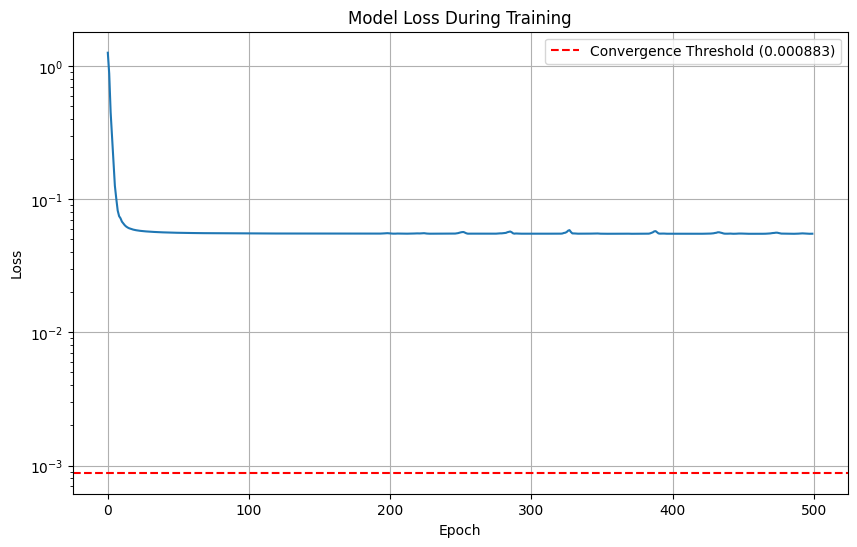

32/32 [==============================] - 0s 2ms/step


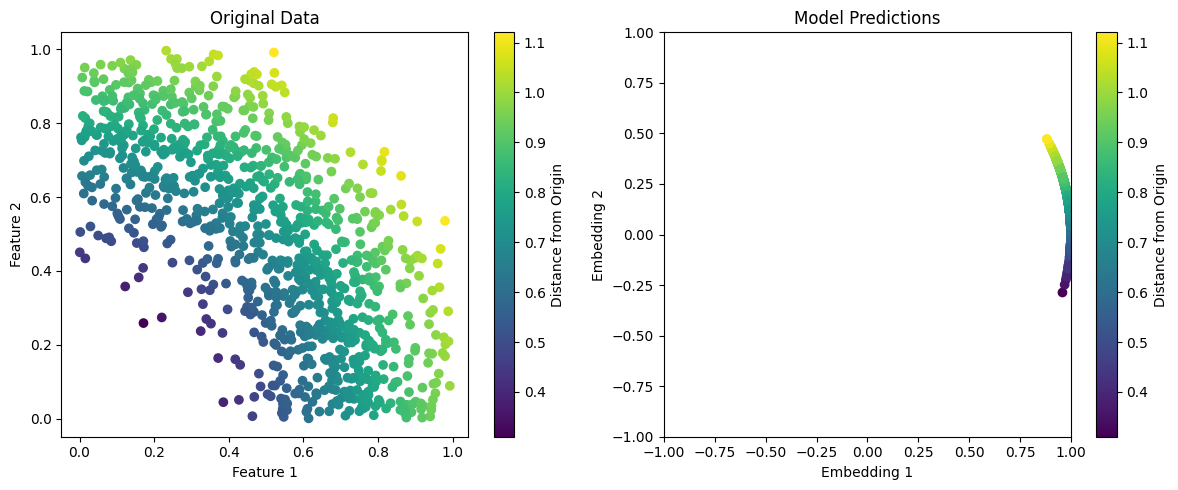

In [22]:
# Usage example with custom loss function
def custom_loss(y_true, y_pred):
    return mb.pdc_loss_linear_vec(y_true, y_pred, pm)  # Replace with appropriate loss function

# Instantiate TrainerV5 with autoencoder enabled
trainer = TrainerV5(input_dim=2, hidden_dims=[8, 16, 32, 16, 8], output_dim=2, ae=True)

# Train the model
history, final_correlation = trainer.train(
    loss_fn=custom_loss,
    num_points=5000,
    epochs=500,
    batch_size=1024
)

# Print results
print(f"Final Pairwise Correlation: {final_correlation:.4f}")

# Plot training history
trainer.plot_training_history(history)

# Generate synthetic data for testing
X_test, y_test = trainer.generate_synthetic_data(num_points=1000)

# Use the encoder model to get the embeddings
predictions = trainer.encoder_model.predict(X_test)

# Plot predictions
trainer.plot_predictions(X_test, y_test, predictions)
